In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

import sys

from analysis import spikingResponse # custom object of trial-aligned spiking reponse
from analysis import pt, crosscorrel # plot_tools and CC-function

import matplotlib.pyplot as plt

# just to disable the HDMF cache namespace warnings, REMOVE to see them
import warnings
warnings.filterwarnings("ignore")

/home/yann.zerlaut/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1) Loading the Optotagging results

In [2]:
#Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()
Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()

# subsample the negative units to 100 cells per session
np.random.seed(1)
for key in ['PV','SST']:
    for n, nUnits in enumerate(Optotagging[key+'_negative_units']):
        Optotagging[key+'_negative_units'][n] = np.random.choice(nUnits, 100, replace=False)

# 2) Preprocess the stimulus-evoked spikes

In [42]:
all = True

tstart, tstop, dt = -1, 301, 1e-3
t = tstart+dt*np.arange(int((tstop-tstart)/dt))

if True:
    # turn True to re-run the analysis
    
    # load data from API
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
    data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
    manifest_path = os.path.join(data_directory, "manifest.json")
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    sessions = cache.get_session_table()
    
    for key in ['PV', 'SST']:
        # loop over session

        for sessionID, positive_units, negative_units in zip(Optotagging[key+'_sessions'],
                                                             Optotagging[key+'_positive_units'],
                                                             Optotagging[key+'_negative_units']):
            if all:
                units  = np.concatenate([positive_units, negative_units])
            else:
                units = positive_units
            
            session = cache.get_session_data(sessionID)
            # stimulus infos for that session
            stim_table = session.get_stimulus_table()
            # fetch summary statistics 
            analysis_metrics = cache.get_unit_analysis_metrics_by_session_type(session.session_type)
            
            for protocol in ['natural_movie_one_more_repeats',
                             'natural_movie_one']:
                if protocol in np.unique(stim_table.stimulus_name):
                    cond = (stim_table.stimulus_name==protocol)
                    # get the number of repeats
                    blocks = np.unique(stim_table[cond].stimulus_block)
                    for unit in units:
                        spike_matrix = np.zeros((len(blocks),len(t)), dtype=bool)
                        # get the spikes of that unit
                        spike_times = session.spike_times[unit]
                        # then just iterate over stimulus block:
                        for trial_idx, b in enumerate(blocks):
                            bCond = cond & (stim_table.stimulus_block==b)
                            trial_start = np.min(stim_table[bCond].start_time)
                            #tstop = np.max(stim_table[bCond].stop_time)
                            in_range = (spike_times > (trial_start + t[0])) * \
                                       (spike_times < (trial_start + t[-1]))
                            binned_times = ((spike_times[in_range] -\
                                             (trial_start + t[0])) / dt).astype('int')
                            spike_matrix[trial_idx, binned_times] = True      
                        Data = {'time_resolution':dt, 
                                'spike_matrix':spike_matrix,
                                't':t, 'keys':['t', 'spike_matrix']}
                        np.save(os.path.join('..', 'data', 'visual_coding', key,
                                             '%s_unit_%i.npy' % ('natural_movie_one', unit)),
                                Data)

# 2) Compute the PSTH

In [3]:
# loop over frames to build the time course
RATES = {}
for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    RATES[key+'_posUnits'] = []
    RATES[key+'_negUnits'] = []
    for sessionID in range(len(Optotagging[key+'_sessions'])):
        for u, rates, units, c in zip(range(2), [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                               [Optotagging[key+'_positive_units'][sessionID], Optotagging[key+'_negative_units'][sessionID]],
                               [color, 'tab:grey']):
            for unit in units:
                filename = os.path.join('..', 'data', 'visual_coding', key, 
                                        '%s_unit_%i.npy' % ('natural_movie_one', unit))
                if os.path.isfile(filename):
                    spikeResp = spikingResponse(None, None, None, filename=filename)
                    rates.append(spikeResp.get_rate(smoothing=5e-3))
time = spikeResp.t

# 3) Plot

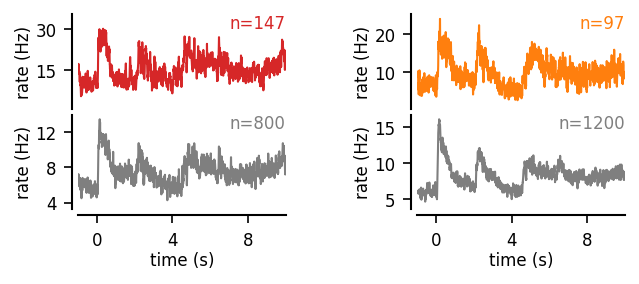

In [5]:
time = spikeResp.t

fig, AX = pt.figure(axes=(2,2), hspace=0.1, figsize=(1.3,1))

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    for u, rates, c in zip(range(2), 
                           [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                           [color, 'tab:grey']):            
        pt.plot(time, np.mean(rates, axis=0), sy=0.*np.std(rates, axis=0), ax=AX[u][k], color=c)
        pt.annotate(AX[u][k], 'n=%i' % len(rates), (1,1), va='top', ha='right', color=c)
        pt.set_plot(AX[u][k], ['left','bottom'] if u else ['left'], 
                    ylabel='rate (Hz)', xlabel='time (s)' if u else '')

for ax in pt.flatten(AX):
    ax.set_xlim([-1,10])

Text(0.5, 0.98, 'cross-correl. "-" vs "+" units')

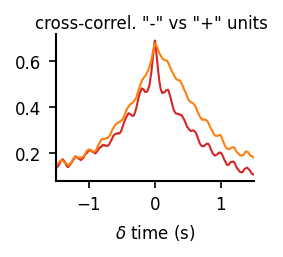

In [6]:
fig, ax = plt.subplots(1) # pt.figure()
ax.set_xlabel('$\delta$ time (s)')
CCF, time_shift = crosscorrel(np.mean(RATES['PV_negUnits'], axis=0),
                              np.mean(RATES['PV_posUnits'], axis=0),
                              1.5, time[1]-time[0])
ax.plot(time_shift, CCF, color='tab:red')

CCF, time_shift = crosscorrel(np.mean(RATES['SST_negUnits'], axis=0),
                              np.mean(RATES['SST_posUnits'], axis=0),
                              1.5, time[1]-time[0])
#ax2 = ax.twinx()
ax.plot(time_shift, CCF, color='tab:orange')
ax.set_xlim([-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')

## Cross-correlation per cell

In [ ]:
CCs = {}
for k, key, color, x in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange'], [ax,ax2]):
    popRate = np.mean(RATES['%s_negUnits' % key], axis=0)
    for u, c in zip(['pos', 'neg'], [color, 'tab:grey']):
        CCs[key+u] = []
        for rate in RATES['%s_%sUnits' % (key,u)][:20]:
            CCF, time_shift = crosscorrel(popRate, rate,
                                          1.5, time[1]-time[0])
            CCs[key+u].append(CCF)

In [ ]:
fig, ax = plt.subplots(1)

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    for u, c in zip(['pos', 'neg'], [color, 'tab:grey']):
        pt.plot(time_shift, np.mean(CCs, axis=0), 
                sy=stats.sem(CCs, axis=0), color=color, ax=ax)

pt.set_plot(ax, xlabel='$\delta$ time (s)', xlim=[-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')